# Tier 2. Module 2: Machine Learning. Fundamentals and Applications
## Topics 07-08 - Supervised learning algorithms P.3
## Homework

This module completes the overview of the basic learning algorithms with the teacher. In particular, the kNN algorithm was considered in the context of classification, which can also be effectively used to solve regression problems. As part of the homework, it is necessary to build a kNN-regressor for forecasting the wages of new employees of the company.

### 1. Import of the required packages

In [1]:
import pandas as pd
import numpy as np
from category_encoders import TargetEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_absolute_percentage_error
import seaborn as sns
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport

### 2. Data loading

In [2]:
data = pd.read_csv('./datasets/mod_04_hw_train_data.csv', sep=',')
data.shape

(249, 9)

In [3]:
data.head()

,Name,Phone_Number,Experience,Qualification,University,Role,Cert,Date_Of_Birth,Salary
0,Jennifer Hernandez,120-602-1220,3.0,Msc,Tier2,Mid,Yes,25/08/1972,98000
1,Timothy Walker,840-675-8650,5.0,PhD,Tier2,Senior,Yes,03/12/2013,135500
2,David Duran,556-293-8643,5.0,Msc,Tier2,Senior,Yes,19/07/2002,123500
3,Gloria Ortega,463-559-7474,3.0,Bsc,Tier3,Mid,No,19/02/1970,85000
4,Matthew Steele,968-091-7683,5.0,Bsc,Tier2,Senior,Yes,20/02/1970,111500


### 3. Exploratory data analysis

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Name           249 non-null    object 
 1   Phone_Number   249 non-null    object 
 2   Experience     247 non-null    float64
 3   Qualification  248 non-null    object 
 4   University     249 non-null    object 
 5   Role           246 non-null    object 
 6   Cert           247 non-null    object 
 7   Date_Of_Birth  249 non-null    object 
 8   Salary         249 non-null    int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 17.6+ KB


Birthday is a string type, not a datetime, for further analysis may be needed to change the format of this column.

In [5]:
data.describe()

,Experience,Salary
count,247.000000,249.000000
mean,3.441296,98186.746988
std,1.496471,23502.622217
min,1.000000,49500.000000
25%,2.000000,78500.000000
50%,4.000000,104500.000000
75%,5.000000,116500.000000
max,5.000000,141500.000000


In [6]:
data.skew(numeric_only=True)

Experience   -0.388337
Salary       -0.343899
dtype: float64

Experience and salary deviate slightly from the normal distribution to the left (small values prevail over large ones), which is natural for any profession when there are fewer young professionals than experienced ones. But the kNN method requires reducing asymmetry to improve predictions.

In [7]:
data.isna().sum()

Name             0
Phone_Number     0
Experience       2
Qualification    1
University       0
Role             3
Cert             2
Date_Of_Birth    0
Salary           0
dtype: int64

The number of empty values in the dataframe is very small, so it's easier to just remove the lines that contain nan. The value of NaN in the experience column may mean a lack of experience or a data entry error. Donald Perkins has too high a salary for an employee with no experience. It is not clear whether it is related to the previous work, or it is really an input error, so it is better to delete all NaN in the salary column as well.

In [8]:
report = ProfileReport(data)
report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

From the report, it can be seen that among the training sample, all employees have a higher education, at the same time, among them there are many people under the age of 22-23, which does not correlate with the availability of a higher education. In addition, almost all birthdays are unique dates, which is unlikely in a real-life situation.

From the preliminary analysis of the data, it can be concluded that the name and phone number are not suitable for salary prediction, so they should be removed. Also the birthdays should be deleted, because the data in this column cannot be considered as reliable.

Remove all rows with any NaN values

In [9]:
df_clean = data.dropna()
df_clean.shape

(241, 9)

Drop Name and Phone columns

In [10]:
df_clean = df_clean.drop(["Name", "Phone_Number", "Date_Of_Birth"], axis=1)
df_clean.shape

(241, 6)

### 4. Data processing
#### 4.1. Preprocessing of numerical features

In [11]:
df_clean.describe()

,Experience,Salary
count,241.000000,241.000000
mean,3.427386,98080.912863
std,1.493010,23554.163839
min,1.000000,49500.000000
25%,2.000000,78000.000000
50%,4.000000,104500.000000
75%,5.000000,116500.000000
max,5.000000,141500.000000


Numerical features distribution

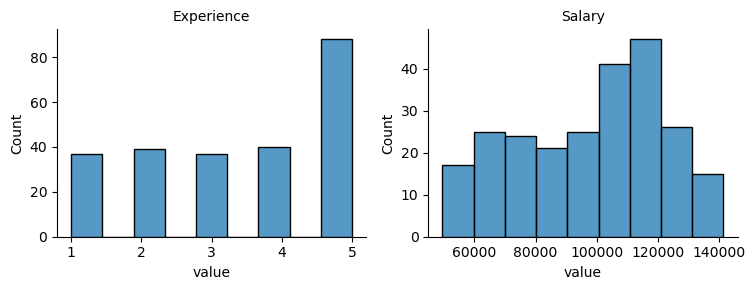

In [12]:
data_num = df_clean.select_dtypes(include=np.number)
melted = data_num.melt()

g = sns.FacetGrid(melted,
                  col='variable',
                  col_wrap=4,
                  sharex=False,
                  sharey=False,
                  aspect=1.25)

g.map(sns.histplot, 'value')

g.set_titles(col_template='{col_name}')

g.tight_layout()

From these graphs, we can conclude that a third of the company's employees have 5 or more years of experience, and at the same time, a quarter of the company is under 30 years old. The fact that all experienced workers were recorded in the same category can make predictions difficult.

Definition of numerical features closely correlated with other features

<Axes: >

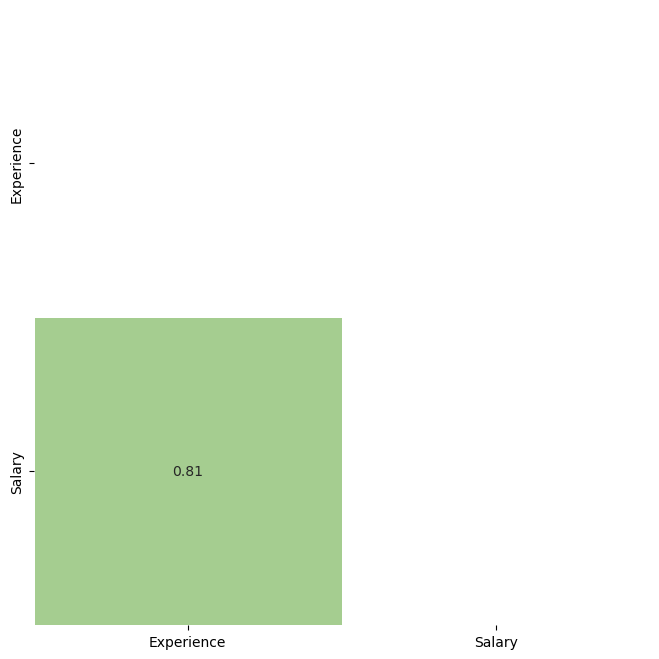

In [13]:
mtx = df_clean.corr(numeric_only=True).abs()

fig, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(mtx,
            cmap='crest',
            annot=True,
            fmt=".2f",
            linewidth=.5,
            mask=np.triu(np.ones_like(mtx, dtype=bool)),
            square=True,
            cbar=False,
            ax=ax)

Salary is strongly correlated with experience.

#### 4.2. Preprocessing of categorical features
Overview of categorical features

In [14]:
df_clean.select_dtypes(include='object').nunique()

Qualification    3
University       3
Role             3
Cert             2
dtype: int64

#### 4.3. Splitting the dataset into features (X) and target (y)

In [15]:
X_train = df_clean.drop(['Salary'], axis=1)
y_train = df_clean['Salary']

#### 4.4. Coding of categorical variables

In [16]:
cat_cols = X_train.select_dtypes(include='object').columns

Coding with target encoder

In [17]:
target_encoder = TargetEncoder(cols=cat_cols)
X_train_target = target_encoder.fit_transform(X_train, y_train)

#### 4.5. Normalization of variables. Reduction of asymmetry

In [18]:
power_transform = PowerTransformer().set_output(transform='pandas')
X_train_power_target = power_transform.fit_transform(X_train_target)
X_train_power_target.skew()

Experience      -0.271511
Qualification    0.000000
University      -0.425908
Role            -0.336508
Cert            -0.075210
dtype: float64

### 5. Building the model

In [19]:
knn_mod = KNeighborsRegressor(
    n_neighbors=7).fit(X_train_power_target, y_train)

### 6. Processing and preparation of data for the validation set

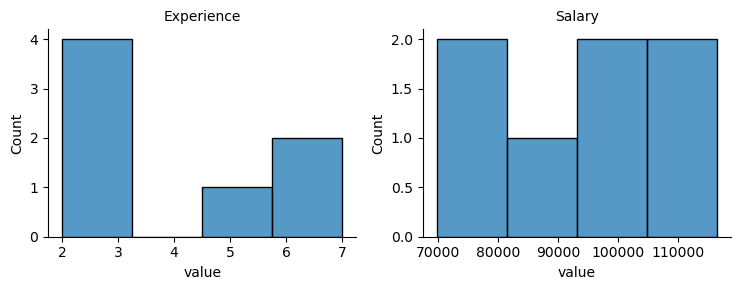

In [20]:
v_data = pd.read_csv('./datasets/mod_04_hw_valid_data.csv', sep=',')

valid_data = v_data.drop(["Name", "Phone_Number", "Date_Of_Birth"], axis=1)

data_num = valid_data.select_dtypes(include=np.number)
melted = data_num.melt()

g = sns.FacetGrid(melted,
                  col='variable',
                  col_wrap=4,
                  sharex=False,
                  sharey=False,
                  aspect=1.25)

g.map(sns.histplot, 'value')

g.set_titles(col_template='{col_name}')

g.tight_layout()

The test set contains data samples with experience greater than 5, while the training set only contains samples up to and including 5. To homogenize the data, we decide to replace experience greater than 5 with 5.

In [21]:
valid_data.loc[valid_data['Experience'] > 5, 'Experience'] = 5

X_test = valid_data.drop(['Salary'], axis=1)
y_test = valid_data['Salary']

X_test_target = target_encoder.transform(X_test, y_test)

X_test_power_target = power_transform.transform(X_test_target)

### 7. Salary forecast

In [22]:
y_pred_power_target = knn_mod.predict(X_test_power_target)

mape = mean_absolute_percentage_error(y_test, y_pred_power_target)

print(f'Validation MAPE: {mape:.2%}')

Validation MAPE: 3.80%


### Conclusion

As a result of the salary prediction, the Mean absolute percentage error was obtained at the level of 3.8%, which is quite a good result but cannot be considered as reliable as the test set is very small. Also some features, such as birthday and the discrepancy of experience in training and testing set doubts about the authenticity and quality of the data set.